#1.Load data

In [1]:
#Import packages required

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import json
import tensorflow

from sklearn.model_selection      import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils                  import to_categorical
from tensorflow.keras             import Sequential, Model, Input
from tensorflow.keras.layers      import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils       import plot_model
from numpy.random                 import seed
seed(1)
tensorflow.random.set_seed(2)

In [2]:
#Download data from Kaggle

!mkdir ~/.kaggle
token = {"username":"gugankailasam","key":"7be55bcc2396ad6d025f6b7e2b3b53b0"}

with open('kaggle.json','w') as file:
  json.dump(token,file)

!cp ./kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
import zipfile
with zipfile.ZipFile("entity-annotated-corpus.zip","r") as zip_ref:
    zip_ref.extractall("data")
!ls

 72% 19.0M/26.4M [00:01<00:00, 8.38MB/s]
100% 26.4M/26.4M [00:01<00:00, 16.1MB/s]
data  entity-annotated-corpus.zip  kaggle.json	sample_data


In [3]:
data = pd.read_csv('/content/data/ner_dataset.csv', encoding= 'unicode_escape')#data//ner_dataset.csv
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
data.shape

(1048575, 4)

#2. Extract mappings required for the neural network

In [5]:
#Generating id's to Word and Tag features
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    
    return tok2idx, idx2tok

token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [6]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx']  = data['Tag'].map(tag2idx)

In [7]:
data.head(10)

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,14491,9
1,NaN,of,IN,O,5946,9
2,NaN,demonstrators,NNS,O,14390,9
3,NaN,have,VBP,O,31789,9
4,NaN,marched,VBN,O,2844,9
5,NaN,through,IN,O,5657,9
6,NaN,London,NNP,B-geo,30133,7
7,NaN,to,TO,O,2510,9
8,NaN,protest,VB,O,13471,9
9,NaN,the,DT,O,23666,9


#3. Transform columns to extract sequential data

In [8]:
data.isna().any()#Check for null values

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [9]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
data_group.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[14491, 5946, 14390, 31789, 2844, 5657, 30133,...","[9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 7, 9, 9, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[32672, 21397, 26787, 11098, 28312, 2510, 2686...","[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[15784, 34949, 14038, 13475, 15291, 9462, 3434...","[9, 9, 8, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 3, ..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[1785, 6738, 17249, 9120, 29173, 5593, 4047, 2...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[15870, 10766, 21927, 4390, 22493, 27578, 6957...","[7, 9, 9, 6, 16, 9, 8, 9, 7, 9, 0, 9, 0, 9, 9,..."
5,Sentence: 10001,"[Mr., Egeland, said, the, latest, figures, sho...","[NNP, NNP, VBD, DT, JJS, NNS, VBP, CD, CD, NNS...","[B-per, I-per, O, O, O, O, O, O, O, O, O, O, O...","[28526, 22493, 27578, 23666, 24249, 24596, 172...","[6, 16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."
6,Sentence: 10002,"[He, said, last, week, 's, tsunami, and, the, ...","[PRP, VBD, JJ, NN, POS, NN, CC, DT, JJ, NN, NN...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[987, 27578, 26485, 2317, 16203, 6929, 2023, 2...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
7,Sentence: 10003,"[Some, 1,27,000, people, are, known, dead, .]","[DT, CD, NNS, VBP, VBN, JJ, .]","[O, O, O, O, O, O, O]","[6715, 25641, 2237, 24991, 21398, 73, 23378]","[9, 9, 9, 9, 9, 9, 9]"
8,Sentence: 10004,"[Aid, is, being, rushed, to, the, region, ,, b...","[NNP, VBZ, VBG, VBN, TO, DT, NN, ,, CC, DT, NN...","[O, O, O, O, O, O, O, O, O, O, B-geo, O, O, O,...","[32548, 22854, 1725, 25800, 2510, 23666, 30016...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, ..."
9,Sentence: 10005,"[Lebanese, politicians, are, condemning, Frida...","[JJ, NNS, VBP, VBG, NNP, POS, NN, NN, IN, DT, ...","[B-gpe, O, O, O, B-tim, O, O, O, O, O, O, O, O...","[14694, 5594, 24991, 20425, 34688, 16203, 2932...","[0, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, ..."


#4. Pad sequences and split the dataset into train, test

In [10]:
#Splitting data into train_tokens, test_tokens, train_tags, test_tags
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.2, train_size=0.8, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 38367 
test_tokens length: 9592 
train_tags: 38367 
test_tags: 9592


#5. Build Model Layout

In [12]:
#Checking input, output dimensions
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [13]:
#Building the model
def get_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))    
    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 32)           1125728   
_________________________________________________________________
lstm (LSTM)                  (None, 104, 32)           8320      
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           561       
Total params: 1,134,609
Trainable params: 1,134,609
Non-trainable params: 0
_________________________________________________________________


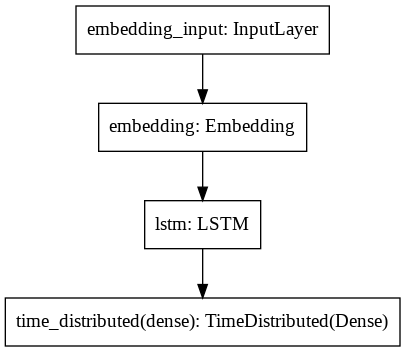

In [14]:
#Training the model
def train_model(X, y, model):
    loss = list()
    for _ in range(10):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split= 0.2)
        loss.append(hist.history['loss'][0])
    return loss

model_lstm = get_lstm_model()
plot_model(model_lstm)#Ploting model to observe its components

In [15]:
results = pd.DataFrame()#Creating dataframe
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_lstm)

31/31 [==============================] - 17s 534ms/step - loss: 0.1222 - accuracy: 0.9697 - val_loss: 0.1082 - val_accuracy: 0.9699


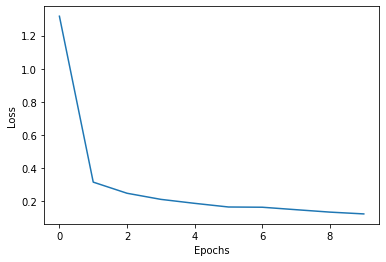

In [16]:
#Plot Loss vs Epochs
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');